In [1]:
""" TODO: 
Import data w/ pandas
Find average cities infected/total infections for each transmission/response percent
Plot both of these on probably colormaps
Also a few quarantine vs num
Try taking out the single-city infections
Compare the hub-only with all cities"""

' TODO: \nImport data w/ pandas\nFind average cities infected/total infections for each transmission/response percent\nPlot both of these on probably colormaps\nAlso a few quarantine vs num\nTry taking out the single-city infections\nCompare the hub-only with all cities'

In [2]:
from __future__ import print_function, division

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

import networkx as nx
import numpy as np
import pandas as pd
import csv

# colors from our friends at http://colorbrewer2.org
COLORS = ['#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462',
          '#b3de69','#fccde5','#d9d9d9','#bc80bd','#ccebc5','#ffed6f']

In [3]:
# Load the output files into Pandas DataFrames for easy parsing
all_file = "output.csv"
node_file = "hub_out.csv"
all_quaran = pd.read_csv(all_file)
node_quaran = pd.read_csv(node_file)

In [4]:
node_quaran.tail()

,transmission,quarantine,total_infections,num_cities_infected
1495,0.5,0.5,77719,1224
1496,0.5,0.5,84817,1214
1497,0.5,0.5,81135,1212
1498,0.5,0.5,81490,1211
1499,0.5,0.5,77022,1223


In [6]:
all_trans_50 = all_quaran.loc[all_quaran.transmission == 0.5]
all_trans_25 = all_quaran.loc[all_quaran.transmission == 0.25]
all_trans_15 = all_quaran.loc[all_quaran.transmission == 0.15]
node_trans_50 = node_quaran.loc[node_quaran.transmission == 0.5]
node_trans_25 = node_quaran.loc[node_quaran.transmission == 0.25]
node_trans_15 = node_quaran.loc[node_quaran.transmission == 0.15]

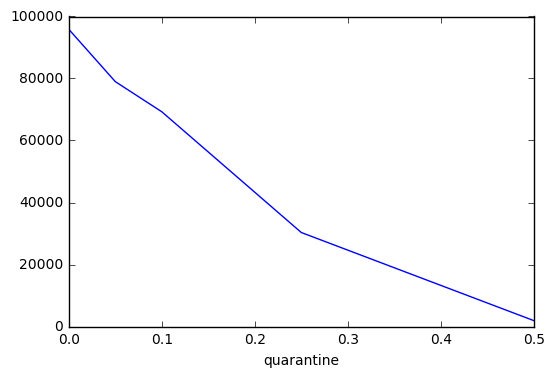

In [7]:
means_all_50 = all_trans_50.groupby('quarantine')['total_infections'].mean()
means_all_50_cities = all_trans_50.groupby('quarantine')['num_cities_infected'].mean()
means_all_50.plot()

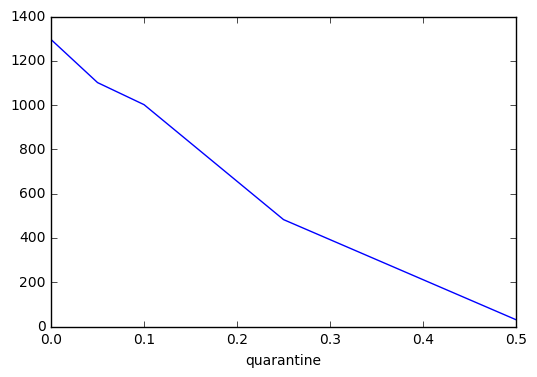

In [8]:
means_all_50_cities.plot()

In [10]:
means_all_15 = all_trans_15.groupby('quarantine')['total_infections'].mean()
means_all_15_cities = all_trans_15.groupby('quarantine')['num_cities_infected'].mean()

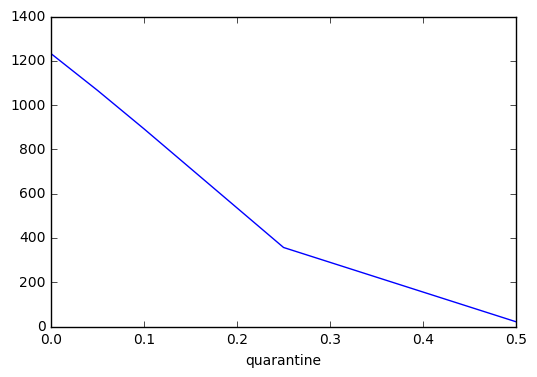

In [11]:
means_all_15_cities.plot()

In [30]:
def infection_subplotter(title, df, axes):
    """ Plots the total infections and cities infected for each response rate from a transmission rate. 
    Uses two axes: left for total infections, right for cities infected
    df: dataframe of the given transmission rate.
    axes: the axes object it is being plotted on
    """
    axes2 = axes.twinx()
    mean_infections = df.groupby('quarantine')['total_infections'].mean()
    mean_cities = df.groupby('quarantine')['num_cities_infected'].mean()
    
    ln1 = axes.plot(mean_infections, 'b-', label = 'Total Infections')
    ln2 = axes2.plot(mean_cities, 'r-', label = 'Number of Infected Cities')
    axes.set_xlabel('Quarantine Response Rate')
    axes.set_ylabel('Infections')
    axes2.set_ylabel('Infected Cities')
    axes.set_title(title)
    lns = ln1 + ln2
    labs = [l.get_label() for l in lns]
    return lns, labs
    
def subplotting_wrapper(df_list):
    """ Given a list of 3 dataframes, makes them into subplots."""
    fig, (ax1, ax2, ax3) = plt.subplots(3,1)
    lns, labs = infection_subplotter('Quarantine Effects for 0.15 Transmission', df_list[0], ax1)
    plt.legend(lns, labs)
    infection_subplotter('Quarantine Effects for 0.25 Transmission', df_list[1], ax2)
    infection_subplotter('Quarantine Effects for 0.50 Transmission', df_list[2], ax3)
    plt.tight_layout()
    fig.set_size_inches(8, 8)


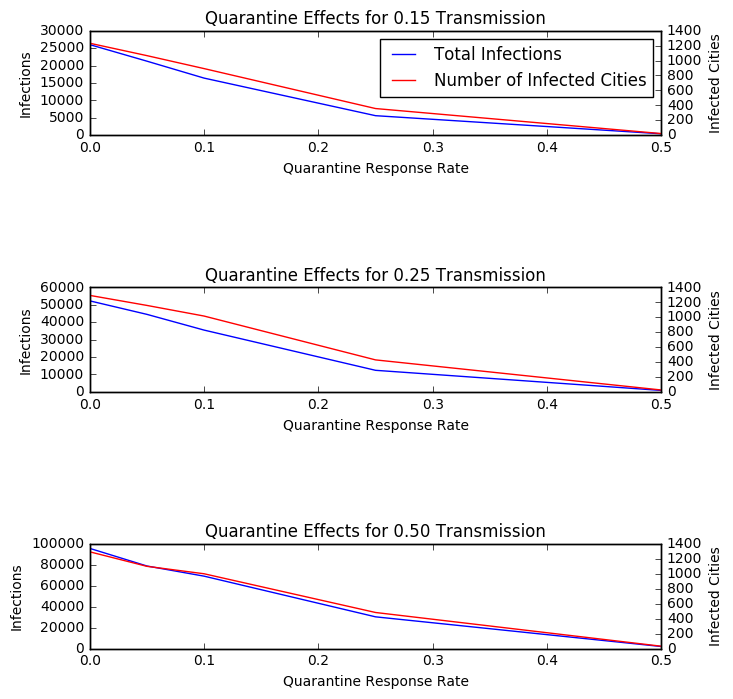

In [31]:
subplotting_wrapper([all_trans_15, all_trans_25, all_trans_50])

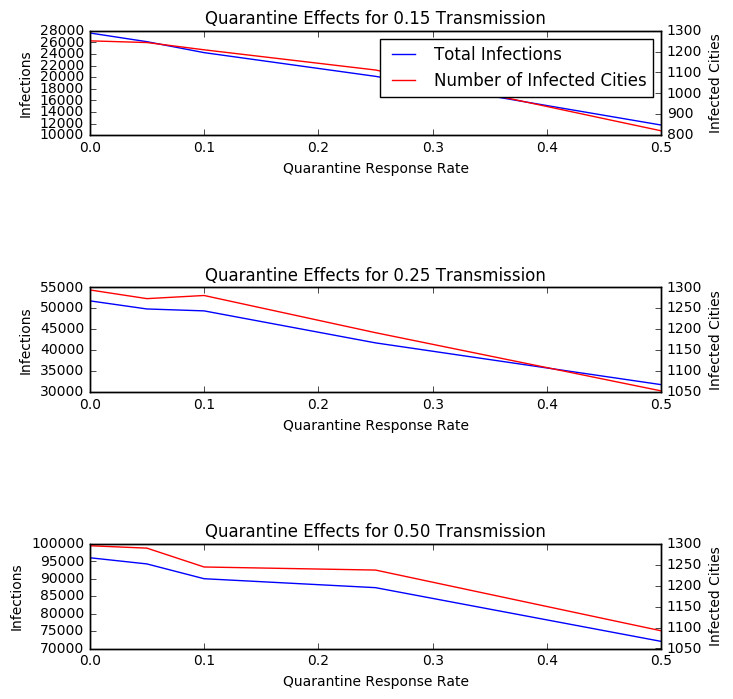

In [32]:
subplotting_wrapper([node_trans_15, node_trans_25, node_trans_50])

In [34]:
means_15 = all_quaran.loc[all_quaran.transmission == 0.15].groupby('quarantine').total_infections.mean()

In [35]:
means_15

quarantine
0.00    26006.86
0.05    21255.49
0.10    16391.37
0.25     5597.22
0.50      393.93
Name: total_infections, dtype: float64

In [49]:
def make_heatmap(df):
    df_means = pd.DataFrame()
    trans_rates = [0.15, 0.25, 0.5]
    quaran_rates = [0, 0.05, 0.1, 0.25, 0.5]
    for rate in trans_rates:
        df_means[rate] = df.loc[df.transmission == rate].groupby('quarantine').num_cities_infected.mean()
    return df_means

In [50]:
df_means = make_heatmap(all_quaran)

In [51]:
df_means

,0.15,0.25,0.5
quarantine,,,
0.00,1232.26,1292.82,1296.00
0.05,1066.13,1158.29,1101.49
0.10,892.42,1015.81,1001.81
0.25,356.83,428.14,482.69
0.50,21.36,24.61,30.56


In [52]:
df_means_nodes = make_heatmap(node_quaran)

In [53]:
df_means_nodes

,0.15,0.25,0.5
quarantine,,,
0.00,1251.54,1293.95,1295.99
0.05,1243.46,1273.08,1290.23
0.10,1208.68,1280.60,1245.10
0.25,1111.94,1191.55,1237.75
0.50,820.69,1052.15,1092.30


In [54]:
import seaborn as sns

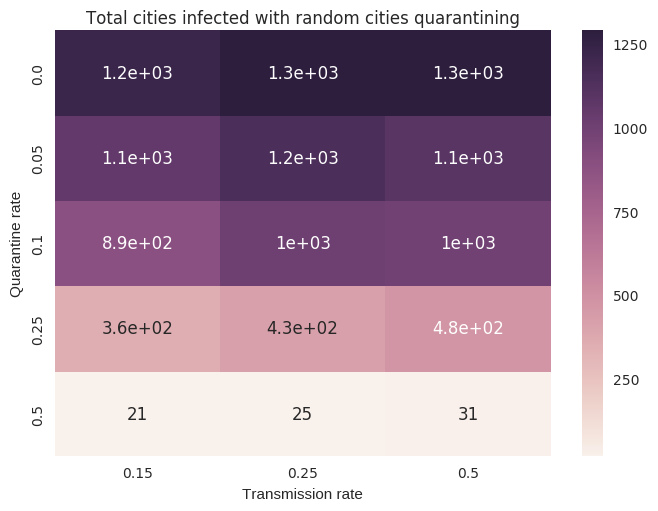

In [59]:
sns.heatmap(df_means, annot=True)
plt.title('Total cities infected with random cities quarantining')
plt.xlabel('Transmission rate')
plt.ylabel('Quarantine rate')

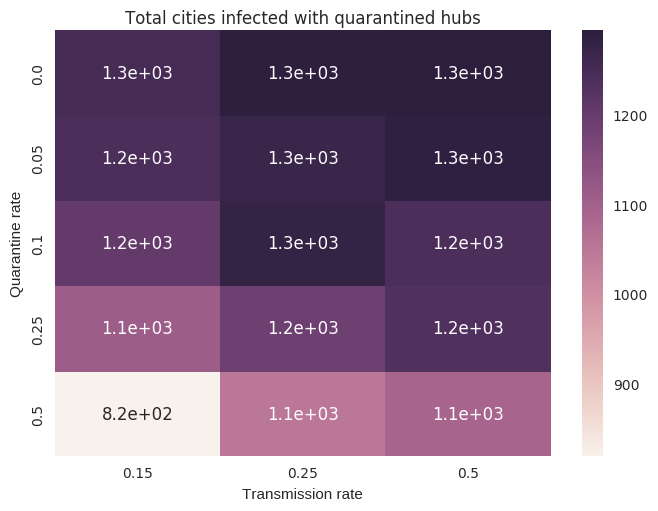

In [60]:
sns.heatmap(df_means_nodes, annot=True)
plt.title('Total cities infected with quarantined hubs')
plt.xlabel('Transmission rate')
plt.ylabel('Quarantine rate')